<a href="https://colab.research.google.com/github/dpatinoecheverri/ENV717_S23/blob/main/Assignments/A05/ENV717_A5_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 5
##ENV717- Spring 2023
---

Instructor: [Dalia Patino-Echeverri ](mailto:dalia.patino@duke.edu)

Author(s): [Mauricio Hernandez](mailto:mmh54@duke.edu)

[Github repository](https://github.com/dpatinoecheverri/ENV717_S23)

In this assignment, you will use eGrid and EIA data to create a supply curve for electricity in ISO New England to analyze the composition of its generation assets and its adequacy to satisfy the demand. 

In [ ]:
#import libraries
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')
#save path
path = "/content/gdrive/MyDrive/ENV717-S2023/A05/"

Mounted at /content/gdrive


# 1 (25%) 

 Extreme weather conditions could cause outages on power plants and transmission lines across New England.  Use [eGRid 2021](https://www.epa.gov/egrid/download-data) $^1$ data and data on peak electricity consumption to analyze the composition of ISO New England’s power generation assets and their adequacy.

 <ol type="a">
  <li>Summarize the total power generation capacity by fuel and the total electricity generation in 2021. Present totals and percentages as shown in the table below.</li>
  <li>Build an electric power supply curve using baseload power plants that have a capacity factor above 1% and a nameplate capacity above 1MW. Assume a competitive wholesale electricity market and make any necessary assumptions for fuel prices. Respond: what is the highest demand the system can serve with these resources?</li>
<li>Repeat b. adding solar and wind power generation resources. Of course, solar and wind resources cannot be counted at full nameplate capacity. Assume that wind and solar resources capacity is equal to their nameplate capacity, de-rated by their average 2021 capacity factor. Respond: what is the highest demand the system can serve with these resources? How much more compared to b.?</li>
<li>What would happen if natural gas demand to heat homes disrupted the supply of fuel to power generators? Repeat b but this time assume that only half of the natural gas capacity is available due to fuel supply disruptions. What is the highest electricity demand that can be served under these conditions?</li>
<li>Repeat d. but consider the situation when supply from nuclear power plants is reduced to 70% of the nameplate capacity. What is the highest electricity demand that can be served under these conditions?</li>
<li>The highest demand observed on a winter day was 22,818 MW (on Thursday 01/15/2014 ).  Is ISONE power supply adequate to meet the peak demand plus reserves? </li>
</ol>


| **Fuel Type**     | **Installed capacity in ISONE in 2021** |                                            | **Generation in 2021** |                                             |
|-------------------|-----------------------------------------|--------------------------------------------|------------------------|---------------------------------------------|
|                   | **MW**                                  | **% of total installed capacity in ISONE** | **MWh**                | **% of total generation capacity in ISONE** |
| Biomass           |                                         |                                            |                        |                                             |
| Coal              |                                         |                                            |                        |                                             |
| Gas               |                                         |                                            |                        |                                             |
| Geothermal        |                                         |                                            |                        |                                             |
| Hydro             |                                         |                                            |                        |                                             |
| Nuclear           |                                         |                                            |                        |                                             |
| Oil               |                                         |                                            |                        |                                             |
| Other fossil fuel |                                         |                                            |                        |                                             |
| Solar             |                                         |                                            |                        |                                             |
| Wind              |                                         |                                            |                        |                                             |
| Other fuel        |                                         |                                            |                        |                                             |

$^1$ 2021 Egrid data was released on 01/30/2023


In [ ]:
###############################################################################################################
## 1. Read eGRID21 file directly form EPA website
## Read the PLNT21 sheet of the excel file into a pandas DataFrame.
## A DataFrame is a two-dimensional labeled data structure with columns of potentially different types
## Specify that the headers are on the second row of the excel file (i.e., row 1 in Python)
## Confirm we read all columns by printing the first five rows
###############################################################################################################
df_plnt = pd.read_excel("https://www.epa.gov/system/files/documents/2023-01/eGRID2021_data.xlsx", 
                       sheet_name="PLNT21", keep_default_na=False, header=1)
#Name of columns
# 2. Select Columns that are needed for the analysis
# ISO RTO name: ISORTO
# Plant primary fuel category: PLFUELCT
# Plant capacity factor: CAPFAC
# Plant nameplate capacity: NAMEPCAP

# These variables are needed for exercise 1b
# Plant annual heat input from combustion (MMBTU): PLHTIAN
# Plant annual net generation (MWh): PLNGENAN

# Also include name of plants
# Plant name: PNAME

# 3. Convert numeric columns to numeric, probably not necesary.
df_plnt.CAPFAC=pd.to_numeric(df_plnt.CAPFAC)
df_plnt.NAMEPCAP=pd.to_numeric(df_plnt.NAMEPCAP)
df_plnt.PLHTIAN=pd.to_numeric(df_plnt.PLHTIAN)
df_plnt.PLNGENAN=pd.to_numeric(df_plnt.PLNGENAN)

#Select only the attributes required, the copy function is recommended, the code 
# works without this function
df_plnt = df_plnt.loc[:,['PNAME', 'ISORTO', 'PLFUELCT', 'CAPFAC', 
                         'NAMEPCAP', 'PLHTIAN', 'PLNGENAN']].copy()
#Show first 5 plants
df_plnt.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN
0,Agrium Kenai Nitrogen Operations,,GAS,NaN,12.5,NaN,NaN
1,Alakanuk,,OIL,0.00000,0.8,NaN,0.000
2,Allison Creek Hydro,,HYDRO,0.30824,6.5,NaN,17551.000
3,Ambler,,OIL,0.13470,1.1,13418.999,1298.000
4,Angoon,,OIL,0.13257,1.5,17910.000,1742.001


### a. Power generation capacity by fuel

In [ ]:
#Summarize the total power generation capacity by fuel and the total electricity 
#generation in 2021. Present totals and percentages as shown in the table below.

#1. Filter plants by ISO/RTO territory, keep only the plants in the 
#  ISO New England ("ISONE")
df_isone = df_plnt.loc[df_plnt.ISORTO == "ISONE"].copy()

#2. Group data by fuel using attribute PLFUELCT
# This can be done with a pivot table, add margins to gert total values
pt_isone_byfuel = pd.pivot_table(df_isone, values=['PLNGENAN', 'NAMEPCAP'], index=['PLFUELCT'],
               aggfunc=np.sum, fill_value=0, margins=False)

pt_isone_byfuel.loc['All']= pt_isone_byfuel.sum(axis=0)

pt_isone_byfuel

,NAMEPCAP,PLNGENAN
PLFUELCT,,
BIOMASS,1405.4,6.940133e+06
COAL,496.4,2.855530e+05
GAS,22289.7,5.614925e+07
HYDRO,3837.1,5.790573e+06
NUCLEAR,3404.9,2.707263e+07
OIL,4483.8,1.580246e+05
OTHF,42.5,-8.440000e+02
SOLAR,2228.0,2.456018e+06
WIND,1523.0,3.662787e+06


In [ ]:
#3. Obtain percentages for installed capacity and generation
# rows are divided by the sum 
pt_isone_byfuel['% Total Installed Capacity'] = 100*(pt_isone_byfuel['NAMEPCAP'] / pt_isone_byfuel.loc['All', 'NAMEPCAP'])
pt_isone_byfuel['% Total Generation'] = 100*(pt_isone_byfuel['PLNGENAN'] / pt_isone_byfuel.loc['All', 'PLNGENAN'])
#3.1 Rename columns
#pt_isone_byfuel.loc['PLNGENAN', 'percent_total_generation']
pt_isone_byfuel.rename(columns={"PLNGENAN": "Generation in 2021 (MWh)", "NAMEPCAP": "Installed Capacity in 2021 (MW)"}, inplace=True)

# show columns in the table in the order
pt_isone_byfuel[['Installed Capacity in 2021 (MW)', '% Total Installed Capacity', 'Generation in 2021 (MWh)', '% Total Generation']] 

,Installed Capacity in 2021 (MW),% Total Installed Capacity,Generation in 2021 (MWh),% Total Generation
PLFUELCT,,,,
BIOMASS,1405.4,3.539088,6.940133e+06,6.769929
COAL,496.4,1.250038,2.855530e+05,0.278550
GAS,22289.7,56.130070,5.614925e+07,54.772208
HYDRO,3837.1,9.662611,5.790573e+06,5.648562
NUCLEAR,3404.9,8.574242,2.707263e+07,26.408681
OIL,4483.8,11.291135,1.580246e+05,0.154149
OTHF,42.5,0.107024,-8.440000e+02,-0.000823
SOLAR,2228.0,5.610564,2.456018e+06,2.395785
WIND,1523.0,3.835229,3.662787e+06,3.572959


In [ ]:
#Save table in folder as csv file
pt_isone_byfuel[['Installed Capacity in 2021 (MW)', 
                 '% Total Installed Capacity', 
                 'Generation in 2021 (MWh)', 
                 '% Total Generation']].to_csv(path + '1a_plants_byfuel_isone.csv')

### b. Electric power supply curve



In [ ]:
# using baseload power plants that have a capacity factor above 1% and a nameplate capacity above 1MW. 
#Assume a competitive wholesale electricity market and make any necessary assumptions for fuel prices. 
# Respond: what is the highest demand the system can serve with these resources?

#1. Filter plants by their capacity factor (>1%)
# and by their nameplate capacity (> 1MW)
mask_capfac = df_isone.CAPFAC > 0.01
mask_namecap = df_isone.NAMEPCAP > 1

# Subset of dataframe with the filters
df_isone_sub = df_isone.loc[mask_capfac & mask_namecap].copy()

In [ ]:
#2. Calculate HEAT RATE
#  HEAT RATE (MMBTU/MWH) = ANNUAL HEAT INPUT (MMBTU)/ANNUAL GENERATION (MWH)
df_isone_sub['HEAT_RATE'] = df_isone_sub.PLHTIAN / df_isone_sub.PLNGENAN
df_isone_sub.head()

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.00,NaN,0.000000
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.82,1.10740,5.758479
2303,Antares-GRE 314 East Lyme LLC,ISONE,SOLAR,0.17286,4.0,NaN,6057.00,NaN,0.000000
2304,Backus Microgrid Project,ISONE,OIL,0.01045,10.4,9591.000,952.00,10.07458,151.118697
2305,Barrett Farm Solar - Phase I,ISONE,SOLAR,0.17741,1.7,NaN,2642.00,NaN,0.000000


In [ ]:
#3. Calculate marginal cost of baseload plants in $/MWh
# Baseload plants are: 'GAS', 'OIL', 'HYDRO', 'BIOMASS', 'NUCLEAR', 'COAL'
#MARGINAL COST [$/MWH] = HEAT RATE (MMBTU/MWH) * COST OF FUEL [$/MMBTU]

# NG and Coal Prices for 2021 from EIA: 
#   https://www.eia.gov/electricity/annual/html/epa_07_01.html
# Biomass price from NREL:
# https://www.statista.com/statistics/190580/us-consumer-price-estimates-for-biomass-since-1970/
# Other sources
# #   https://www.nrel.gov/docs/gen/fy09/42857.pdf
# https://www.epa.gov/sites/default/files/2015-07/documents/biomass_combined_heat_and_power_catalog_of_technologies_7._representative_biomass_chp_system_cost_and_performance_profiles.pdf

MARG_COST_NUCLEAR = 9 #$/MWh
MARG_COST_HYDRO = 6 #$/MWh
AVG_PRICE_NG = 5.20 #$/MMBtu 
AVG_PRICE_COAL = 1.98 #$/MMBtu
AVG_PRICE_OIL = 15 #$/MMBtu
AVG_PRICE_BIOM = 3.22 #$/MMBtu

# Create new attribute to store the marginal cost
# Initially all the values are zero
df_isone_sub['MARG_COST'] = 0

# Replace the marginal costs of nuclear and hydro plants by the given cost
df_isone_sub.loc[df_isone_sub.PLFUELCT=='NUCLEAR','MARG_COST'] = MARG_COST_NUCLEAR
df_isone_sub.loc[df_isone_sub.PLFUELCT=='HYDRO','MARG_COST'] = MARG_COST_HYDRO

# Replace the marginal costs of coal, NG, oil and biomass plants by: heat rate * fuel cost
df_isone_sub.loc[df_isone_sub.PLFUELCT=='COAL','MARG_COST'] = df_isone_sub.HEAT_RATE*AVG_PRICE_COAL
df_isone_sub.loc[df_isone_sub.PLFUELCT=='GAS','MARG_COST'] = df_isone_sub.HEAT_RATE*AVG_PRICE_NG
df_isone_sub.loc[df_isone_sub.PLFUELCT=='OIL','MARG_COST'] = df_isone_sub.HEAT_RATE*AVG_PRICE_OIL
df_isone_sub.loc[df_isone_sub.PLFUELCT=='BIOMASS','MARG_COST'] = df_isone_sub.HEAT_RATE*AVG_PRICE_BIOM

#Show the first 5 values
df_isone_sub.head(n=5)
#df_isone_sub.info()

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.00,NaN,0.000000
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.82,1.10740,5.758479
2303,Antares-GRE 314 East Lyme LLC,ISONE,SOLAR,0.17286,4.0,NaN,6057.00,NaN,0.000000
2304,Backus Microgrid Project,ISONE,OIL,0.01045,10.4,9591.000,952.00,10.07458,151.118697
2305,Barrett Farm Solar - Phase I,ISONE,SOLAR,0.17741,1.7,NaN,2642.00,NaN,0.000000


In [ ]:
#4. Keep baseload power plants by filtering the plants by their type of fuel
list_fuel_base = ['GAS', 'OIL', 'HYDRO', 'BIOMASS', 'NUCLEAR', 'COAL']
df_isone_base = df_isone_sub[df_isone_sub.PLFUELCT.isin(list_fuel_base)].copy()

df_isone_base.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,1.492097e+05,134738.82,1.107400,5.758479
2304,Backus Microgrid Project,ISONE,OIL,0.01045,10.4,9.591000e+03,952.00,10.074580,151.118697
2309,Bradley Energy Center,ISONE,GAS,0.27307,5.8,8.990384e+04,13874.00,6.480023,33.696118
2312,Bridge Street 1 & 2,ISONE,OIL,0.01098,5.2,5.239000e+03,500.00,10.478000,157.170000
2313,Bridgeport Energy,ISONE,GAS,0.50379,520.0,1.593573e+07,2294863.00,6.944087,36.109251


In [ ]:
#5. Build a Supply Curve of Electricity
#5.1. Sort plants by merit order. This is from the cheapest to the most expensive
df_isone_base.sort_values("MARG_COST", inplace=True)
df_isone_base.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST
4547,MIT Central Utility Plant,ISONE,GAS,0.14300,64.6,56638.155,80921.000,0.699919,3.639579
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.820,1.107400,5.758479
4996,Pittsfield Hydro,ISONE,HYDRO,0.36768,1.1,NaN,3543.001,NaN,6.000000
5009,Rumford Falls Hydro Facility,ISONE,HYDRO,0.53607,44.5,NaN,208970.999,NaN,6.000000
5013,Salmon Falls,ISONE,HYDRO,0.14298,1.2,NaN,1503.000,NaN,6.000000


In [ ]:
# 6. Create a column with the cummulative capacity [MW] offered at that MARG_COST
# this info is needed to draw the supply curve
df_isone_base['CUM_CAP'] = df_isone_base.NAMEPCAP.cumsum(skipna=False)
df_isone_base.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,CUM_CAP
4547,MIT Central Utility Plant,ISONE,GAS,0.14300,64.6,56638.155,80921.000,0.699919,3.639579,64.6
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.820,1.107400,5.758479,135.6
4996,Pittsfield Hydro,ISONE,HYDRO,0.36768,1.1,NaN,3543.001,NaN,6.000000,136.7
5009,Rumford Falls Hydro Facility,ISONE,HYDRO,0.53607,44.5,NaN,208970.999,NaN,6.000000,181.2
5013,Salmon Falls,ISONE,HYDRO,0.14298,1.2,NaN,1503.000,NaN,6.000000,182.4


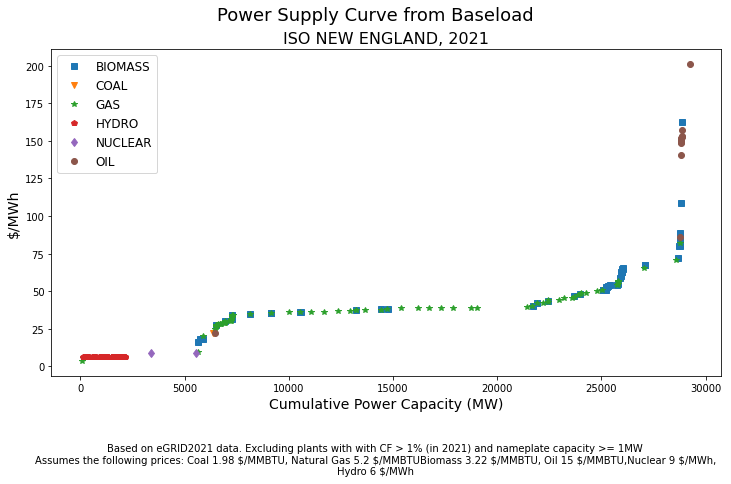

In [ ]:
# 7. Create the supply curve using a scatter plot
# To distinguish the plants by type of fuel we will use different markers
groups = df_isone_base.groupby("PLFUELCT")
list_markers = ['s','v','*','p','d','o','x','+','>','2']

plt.figure(figsize=(12,6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP"], group["MARG_COST"], marker=list_markers[counter], 
             linestyle="", label=name)
    counter = counter + 1

#Add titles and label axes
plt.suptitle('Power Supply Curve from Baseload',
          fontsize=18)
plt.title('ISO NEW ENGLAND, 2021', fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2021 data. Excluding plants with with CF > 1% (in 2021) and nameplate capacity >= 1MW"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10)

txt2_1 = 'Assumes the following prices: Coal {} $/MMBTU, Natural Gas {} $/MMBTU'
txt2_2 = 'Biomass {} $/MMBTU, Oil {} $/MMBTU,Nuclear {} $/MWh, Hydro {} $/MWh'
txt2= (txt2_1 + txt2_2).format(AVG_PRICE_COAL, AVG_PRICE_NG, AVG_PRICE_BIOM, 
                               AVG_PRICE_OIL, MARG_COST_NUCLEAR,MARG_COST_HYDRO)
plt.figtext(0.5, -0.1, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + '1b_isone_baseload_power_supply_curve.png')
plt.show()

---
**What is the highest demand the system can serve with these resources?**


In [ ]:
# Estimating the maximum capacity from plants
total_capac_base = df_isone_base.NAMEPCAP.sum()

print("""The maximum demand that can be served in ISO New England with baseload 
      resources that have an installed capacity of more than 1MW and in 2021 
      had a capacity factor of more than 1% is: {:,.2f} MW.""".format(total_capac_base))

The maximum demand that can be served in ISO New England with baseload 
      resources that have an installed capacity of more than 1MW and in 2021 
      had a capacity factor of more than 1% is: 29,352.70 MW.


### c. Supply curve - Adding solar and wind power generation resources

In [ ]:
#1. Keep baseload power plants and solar and wind by filtering the plants by their type of fuel
list_fuel_all = ['GAS', 'OIL', 'HYDRO', 'BIOMASS', 'NUCLEAR', 'COAL', 'SOLAR', 'WIND']
df_isone_all = df_isone_sub[df_isone_sub.PLFUELCT.isin(list_fuel_all)].copy()

df_isone_all.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.00,NaN,0.000000
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.82,1.10740,5.758479
2303,Antares-GRE 314 East Lyme LLC,ISONE,SOLAR,0.17286,4.0,NaN,6057.00,NaN,0.000000
2304,Backus Microgrid Project,ISONE,OIL,0.01045,10.4,9591.000,952.00,10.07458,151.118697
2305,Barrett Farm Solar - Phase I,ISONE,SOLAR,0.17741,1.7,NaN,2642.00,NaN,0.000000


In [ ]:
#2. Adjust nameplate capacity for solar and wind units
# Create new attribute to store the adjusted nameplate capacity
# Initially all the values are equal to the original nameplate capacity
df_isone_all['NAMEPCAP_ADJ'] = df_isone_all.NAMEPCAP

# Replace the nameplate capacity of solar and wind plants by their nameplate capacity, 
# de-rated by their average 2021 capacity factor.
df_isone_all.loc[df_isone_all.PLFUELCT=='SOLAR','NAMEPCAP_ADJ'] = df_isone_all.NAMEPCAP * df_isone_all.CAPFAC
df_isone_all.loc[df_isone_all.PLFUELCT=='WIND','NAMEPCAP_ADJ'] = df_isone_all.NAMEPCAP * df_isone_all.CAPFAC

df_isone_all.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,NAMEPCAP_ADJ
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.00,NaN,0.000000,0.167004
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.82,1.10740,5.758479,71.000000
2303,Antares-GRE 314 East Lyme LLC,ISONE,SOLAR,0.17286,4.0,NaN,6057.00,NaN,0.000000,0.691440
2304,Backus Microgrid Project,ISONE,OIL,0.01045,10.4,9591.000,952.00,10.07458,151.118697,10.400000
2305,Barrett Farm Solar - Phase I,ISONE,SOLAR,0.17741,1.7,NaN,2642.00,NaN,0.000000,0.301597


In [ ]:
#3. Build a Supply Curve of Electricity (the next steps are repeated from previous exercise)
#3.1. Sort plants by merit order. This is from the cheapest to the most expensive
df_isone_all.sort_values("MARG_COST", inplace=True)
df_isone_all.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,NAMEPCAP_ADJ
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.0,NaN,0.0,0.167004
4671,Sunpin Blandford,ISONE,SOLAR,0.11049,4.7,NaN,4549.0,NaN,0.0,0.519303
4673,Sutton Solar CSG,ISONE,SOLAR,0.18878,1.9,NaN,3142.0,NaN,0.0,0.358682
4674,Syncarpha Blandford Hybrid CSG,ISONE,SOLAR,0.10261,8.8,0.0,7910.0,0.0,0.0,0.902968
4675,Syncarpha Freetown,ISONE,SOLAR,0.19207,3.9,NaN,6562.0,NaN,0.0,0.749073


In [ ]:
# 4. Create a column with the cummulative capacity [MW] offered at that MARG_COST
# this info is needed to draw the supply curve
df_isone_all['CUM_CAP_ADJ'] = df_isone_all.NAMEPCAP_ADJ.cumsum(skipna=False)
df_isone_all.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,NAMEPCAP_ADJ,CUM_CAP_ADJ
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.0,NaN,0.0,0.167004,0.167004
4671,Sunpin Blandford,ISONE,SOLAR,0.11049,4.7,NaN,4549.0,NaN,0.0,0.519303,0.686307
4673,Sutton Solar CSG,ISONE,SOLAR,0.18878,1.9,NaN,3142.0,NaN,0.0,0.358682,1.044989
4674,Syncarpha Blandford Hybrid CSG,ISONE,SOLAR,0.10261,8.8,0.0,7910.0,0.0,0.0,0.902968,1.947957
4675,Syncarpha Freetown,ISONE,SOLAR,0.19207,3.9,NaN,6562.0,NaN,0.0,0.749073,2.697030


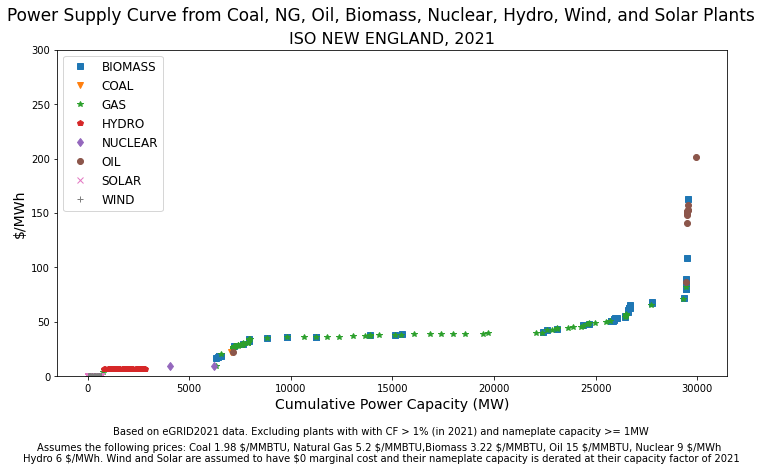

In [ ]:
# 5. Create the supply curve using a scatter plot
# To distinguish the plants by type of fuel we will use different markers
groups = df_isone_all.groupby("PLFUELCT")
list_markers = ['s','v','*','p','d','o','x','+','>','2']

plt.figure(figsize=(12,6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP_ADJ"], group["MARG_COST"], marker=list_markers[counter], 
             linestyle="", label=name)
    counter = counter + 1

#Add titles and label axes
plt.suptitle('Power Supply Curve from Coal, NG, Oil, Biomass, Nuclear, Hydro, Wind, and Solar Plants',
          fontsize=17)
plt.title('ISO NEW ENGLAND, 2021', fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.ylim([0,300])
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2021 data. Excluding plants with with CF > 1% (in 2021) and nameplate capacity >= 1MW"
plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

txt2_1 = 'Assumes the following prices: Coal {} \$/MMBTU, Natural Gas {} \$/MMBTU,'
txt2_2 = 'Biomass {} \$/MMBTU, Oil {} \$/MMBTU, Nuclear {} \$/MWh \n'
txt2_3 = 'Hydro {} \$/MWh. Wind and Solar are assumed to have \$0 marginal cost '
txt2_4 = 'and their nameplate capacity is derated at their capacity factor of 2021'
txt2= (txt2_1 + txt2_2 + txt2_3 + txt2_4).format(AVG_PRICE_COAL, AVG_PRICE_NG, 
                                                 AVG_PRICE_BIOM, AVG_PRICE_OIL, 
                                                 MARG_COST_NUCLEAR,MARG_COST_HYDRO)
plt.figtext(0.5, -0.07, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + '1c_isone_all_power_supply_curve.png')
plt.show()

**What is the highest demand the system can serve with these resources?**

In [ ]:
# Estimating the maximum capacity from baseload plants
total_capac_all = df_isone_all.NAMEPCAP_ADJ.sum()

#This is a total of 572.41 MW more than if just baseload plants are considered.

print('The maximum demand that can be served in ISO New England with baseload \n' + 
      'resources PLUS SOLAR AND WIND that have an installed capacity of more than  \n' + 
      '1MW and in 2021 had a capacity factor of more than 1% is: {:,.2f} MW.'.format(total_capac_all))

The maximum demand that can be served in ISO New England with baseload 
resources PLUS SOLAR AND WIND that have an installed capacity of more than  
1MW and in 2021 had a capacity factor of more than 1% is: 30,037.79 MW.


**How much more compared to b.?**

In [ ]:
print('This is a total of {:,.2f} MW more than if just baseload plants are considered.'.format(total_capac_all - total_capac_base))

This is a total of 685.09 MW more than if just baseload plants are considered.


### d. Natural gas demand disruption
**What would happen if natural gas demand to heat homes disrupted the supply of fuel to power generators?**

In [ ]:

#1. Adjust nameplate capacity for natural gas plants
# Create new attribute to store the NG disrupted nameplate capacity
# Initially all the values are equal to the original nameplate
df_isone_base['NAMEPCAP_DISRUPT_NG'] = df_isone_base.NAMEPCAP

# Replace the nameplate capacity of NG plants by half of their nameplate capacity
df_isone_base.loc[df_isone_base.PLFUELCT=='GAS', 'NAMEPCAP_DISRUPT_NG'] = df_isone_base.NAMEPCAP * 0.5
df_isone_base.head(n=5)


,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,CUM_CAP,NAMEPCAP_DISRUPT_NG
4547,MIT Central Utility Plant,ISONE,GAS,0.14300,64.6,56638.155,80921.000,0.699919,3.639579,64.6,32.3
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.820,1.107400,5.758479,135.6,35.5
4996,Pittsfield Hydro,ISONE,HYDRO,0.36768,1.1,NaN,3543.001,NaN,6.000000,136.7,1.1
5009,Rumford Falls Hydro Facility,ISONE,HYDRO,0.53607,44.5,NaN,208970.999,NaN,6.000000,181.2,44.5
5013,Salmon Falls,ISONE,HYDRO,0.14298,1.2,NaN,1503.000,NaN,6.000000,182.4,1.2


In [ ]:
# 2. Create a column with the cummulative capacity [MW] offered at that MARG_COST
# this info is needed to draw the supply curve
df_isone_base['CUM_CAP_DISRUPT_NG'] = df_isone_base.NAMEPCAP_DISRUPT_NG.cumsum(skipna=False)
#Show first 5 NG planst to see the disrupted nameplate capacity
df_isone_base.loc[df_isone_all.PLFUELCT == 'GAS',].head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,CUM_CAP,NAMEPCAP_DISRUPT_NG,CUM_CAP_DISRUPT_NG
4547,MIT Central Utility Plant,ISONE,GAS,0.14300,64.6,56638.155,80921.00,0.699919,3.639579,64.6,32.3,32.3
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.82,1.107400,5.758479,135.6,35.5,67.8
4928,Androscoggin Mill,ISONE,GAS,0.14065,80.0,180881.580,98565.00,1.835150,9.542781,5630.7,40.0,5522.9
9482,Central Power Plant,ISONE,GAS,0.26890,11.0,99983.065,25911.00,3.858711,20.065298,5889.2,5.5,5775.9
4426,Gillette SBMC,ISONE,GAS,0.56534,14.2,333850.243,70324.00,4.747316,24.686043,6469.5,7.1,6349.1


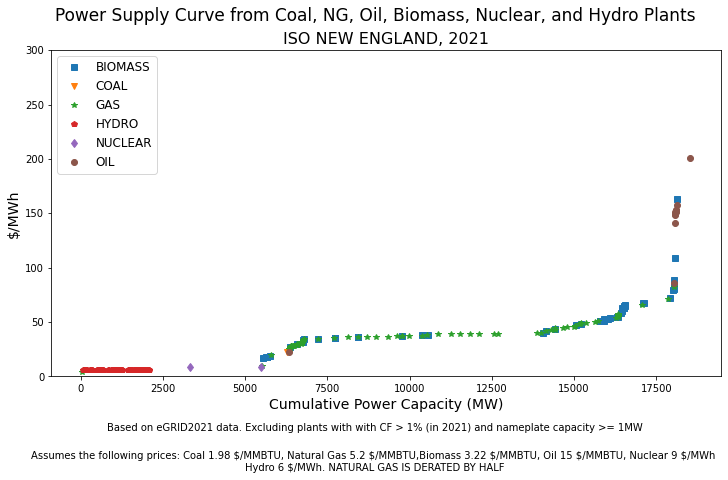

In [ ]:
# 3. Create the supply curve using a scatter plot
# To distinguish the plants by type of fuel we will use different markers
groups = df_isone_base.groupby("PLFUELCT")
list_markers = ['s','v','*','p','d','o','x','+','>','2']

plt.figure(figsize=(12, 6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP_DISRUPT_NG"], group["MARG_COST"], marker=list_markers[counter], 
             linestyle="", label=name)
    counter = counter + 1

#Add titles and label axes
plt.suptitle('Power Supply Curve from Coal, NG, Oil, Biomass, Nuclear, and Hydro Plants',
          fontsize=17)
plt.title('ISO NEW ENGLAND, 2021', fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.ylim([0,300])
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2021 data. Excluding plants with with CF > 1% (in 2021) and nameplate capacity >= 1MW"
plt.figtext(0.5, 0.0, txt, wrap=True, horizontalalignment='center', fontsize=10)

txt2_1 = 'Assumes the following prices: Coal {} \$/MMBTU, Natural Gas {} \$/MMBTU,'
txt2_2 = 'Biomass {} \$/MMBTU, Oil {} \$/MMBTU, Nuclear {} \$/MWh \n'
txt2_3 = 'Hydro {} \$/MWh. NATURAL GAS IS DERATED BY HALF'

txt2= (txt2_1 + txt2_2 + txt2_3).format(AVG_PRICE_COAL, AVG_PRICE_NG, 
                                        AVG_PRICE_BIOM, AVG_PRICE_OIL, 
                                        MARG_COST_NUCLEAR,MARG_COST_HYDRO)
plt.figtext(0.5, -0.09, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + '1d_isone_ng_derated_power_supply_curve.png')
plt.show()

In [ ]:
# Estimating the maximum capacity from plants
total_capac_ng_disrupt = df_isone_base.NAMEPCAP_DISRUPT_NG.sum()

print("""The maximum demand that can be served in ISO New England with the power 
    plants contained in the PLNT21 tab of eGRID2021, that had a capacity of more 
    than 1 MW and a CF of more than 1%, derating the capacity of NATURAL GAS 
    plants by half is {:,.2f} MW.""".format(total_capac_ng_disrupt))

The maximum demand that can be served in ISO New England with the power 
    plants contained in the PLNT21 tab of eGRID2021, that had a capacity of more 
    than 1 MW and a CF of more than 1%, derating the capacity of NATURAL GAS 
    plants by half is 18,588.85 MW.


#### If solar and wind (not derated) are also included:

In [ ]:
#1. Adjust nameplate capacity for natural gas plants
# Create new attribute to store the NG disrupted nameplate capacity
# Initially all the values are equal to the original nameplate
df_isone_all['NAMEPCAP_DISRUPT_NG'] = df_isone_all.NAMEPCAP

# Replace the nameplate capacity of NG plants by half of their nameplate capacity
df_isone_all.loc[df_isone_all.PLFUELCT=='GAS', 'NAMEPCAP_DISRUPT_NG'] = df_isone_all.NAMEPCAP * 0.5
df_isone_all.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,NAMEPCAP_ADJ,CUM_CAP_ADJ,NAMEPCAP_DISRUPT_NG
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.0,NaN,0.0,0.167004,0.167004,1.2
4671,Sunpin Blandford,ISONE,SOLAR,0.11049,4.7,NaN,4549.0,NaN,0.0,0.519303,0.686307,4.7
4673,Sutton Solar CSG,ISONE,SOLAR,0.18878,1.9,NaN,3142.0,NaN,0.0,0.358682,1.044989,1.9
4674,Syncarpha Blandford Hybrid CSG,ISONE,SOLAR,0.10261,8.8,0.0,7910.0,0.0,0.0,0.902968,1.947957,8.8
4675,Syncarpha Freetown,ISONE,SOLAR,0.19207,3.9,NaN,6562.0,NaN,0.0,0.749073,2.697030,3.9


In [ ]:
# 2. Create a column with the cummulative capacity [MW] offered at that MARG_COST
# this info is needed to draw the supply curve
df_isone_all['CUM_CAP_DISRUPT_NG'] = df_isone_all.NAMEPCAP_DISRUPT_NG.cumsum(skipna=False)
#Show first 5 NG planst to see the disrupted nameplate capacity
df_isone_all.loc[df_isone_all.PLFUELCT == 'GAS',].head(n=5)


,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,NAMEPCAP_ADJ,CUM_CAP_ADJ,NAMEPCAP_DISRUPT_NG,CUM_CAP_DISRUPT_NG
4547,MIT Central Utility Plant,ISONE,GAS,0.14300,64.6,56638.155,80921.00,0.699919,3.639579,64.6,749.693103,32.3,3372.5
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.82,1.107400,5.758479,71.0,820.693103,35.5,3408.0
4928,Androscoggin Mill,ISONE,GAS,0.14065,80.0,180881.580,98565.00,1.835150,9.542781,80.0,6315.793103,40.0,8863.1
9482,Central Power Plant,ISONE,GAS,0.26890,11.0,99983.065,25911.00,3.858711,20.065298,11.0,6574.293103,5.5,9116.1
4426,Gillette SBMC,ISONE,GAS,0.56534,14.2,333850.243,70324.00,4.747316,24.686043,14.2,7154.593103,7.1,9689.3


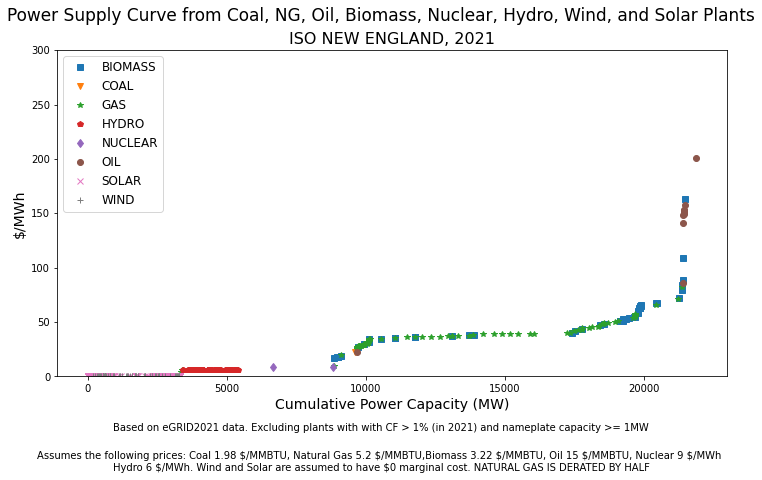

In [ ]:
# 3. Create the supply curve using a scatter plot
# To distinguish the plants by type of fuel we will use different markers
groups = df_isone_all.groupby("PLFUELCT")
list_markers = ['s','v','*','p','d','o','x','+','>','2']

plt.figure(figsize=(12, 6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP_DISRUPT_NG"], group["MARG_COST"], marker=list_markers[counter], 
             linestyle="", label=name)
    counter = counter + 1

#Add titles and label axes
plt.suptitle('Power Supply Curve from Coal, NG, Oil, Biomass, Nuclear, Hydro, Wind, and Solar Plants',
          fontsize=17)
plt.title('ISO NEW ENGLAND, 2021', fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.ylim([0,300])
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2021 data. Excluding plants with with CF > 1% (in 2021) and nameplate capacity >= 1MW"
plt.figtext(0.5, 0.0, txt, wrap=True, horizontalalignment='center', fontsize=10)

txt2_1 = 'Assumes the following prices: Coal {} \$/MMBTU, Natural Gas {} \$/MMBTU,'
txt2_2 = 'Biomass {} \$/MMBTU, Oil {} \$/MMBTU, Nuclear {} \$/MWh \n'
txt2_3 = 'Hydro {} \$/MWh. Wind and Solar are assumed to have \$0 marginal cost. '
txt2_4 = 'NATURAL GAS IS DERATED BY HALF'

txt2= (txt2_1 + txt2_2 + txt2_3 + txt2_4).format(AVG_PRICE_COAL, AVG_PRICE_NG, 
                                                 AVG_PRICE_BIOM, AVG_PRICE_OIL, 
                                                 MARG_COST_NUCLEAR,MARG_COST_HYDRO)
plt.figtext(0.5, -0.09, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + '1d_isone_ng_derated_power_supply_curve_with_solar_wind.png')
plt.show()


 What is the highest electricity demand that can
be served under these conditions?

In [ ]:
# Estimating the maximum capacity from plants
total_capac_ng_disrupt_solar_wind = df_isone_all.NAMEPCAP_DISRUPT_NG.sum()

print("""The maximum demand that can be served in ISO New England with the power 
    plants contained in the PLNT21 tab of eGRID2021, that had a capacity of more 
    than 1 MW and a CF of more than 1%, without derating WIND AND SOLAR and 
    derating the capacity of NATURAL GAS plants by half is {:,.2f} MW.""".format(total_capac_ng_disrupt_solar_wind))

The maximum demand that can be served in ISO New England with the power 
    plants contained in the PLNT21 tab of eGRID2021, that had a capacity of more 
    than 1 MW and a CF of more than 1%, without derating WIND AND SOLAR and 
    derating the capacity of NATURAL GAS plants by half is 21,929.05 MW.


## e. Nuclear power plants reduction to 70% plus NG demand disruption

In [ ]:
#1. Adjust nameplate capacity for natural gas plants
# Create new attribute to store the Nuclear plants  disrupted nameplate capacity
# Initially all the values are equal to the original nameplate
df_isone_base['NAMEPCAP_DISRUPT_NUCLEAR'] = df_isone_base.NAMEPCAP_DISRUPT_NG

# Replace the nameplate capacity of NG plants by half of their nameplate capacity
df_isone_base.loc[df_isone_all.PLFUELCT=='NUCLEAR', 'NAMEPCAP_DISRUPT_NUCLEAR'] = df_isone_base.NAMEPCAP * 0.70
df_isone_base.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,CUM_CAP,NAMEPCAP_DISRUPT_NG,CUM_CAP_DISRUPT_NG,NAMEPCAP_DISRUPT_NUCLEAR
4547,MIT Central Utility Plant,ISONE,GAS,0.14300,64.6,56638.155,80921.000,0.699919,3.639579,64.6,32.3,32.3,32.3
2301,"Algonquin Power Windsor Locks, LLC",ISONE,GAS,0.21664,71.0,149209.734,134738.820,1.107400,5.758479,135.6,35.5,67.8,35.5
4996,Pittsfield Hydro,ISONE,HYDRO,0.36768,1.1,NaN,3543.001,NaN,6.000000,136.7,1.1,68.9,1.1
5009,Rumford Falls Hydro Facility,ISONE,HYDRO,0.53607,44.5,NaN,208970.999,NaN,6.000000,181.2,44.5,113.4,44.5
5013,Salmon Falls,ISONE,HYDRO,0.14298,1.2,NaN,1503.000,NaN,6.000000,182.4,1.2,114.6,1.2


In [ ]:
# 2. Create a column with the cummulative capacity [MW] offered at that MARG_COST
# this info is needed to draw the supply curve
df_isone_base['CUM_CAP_DISRUPT_NUCLEAR'] = df_isone_base.NAMEPCAP_DISRUPT_NUCLEAR.cumsum(skipna=False)
#Show first 5 NUCLEAR planst to see the disrupted nameplate capacity
df_isone_base.loc[df_isone_all.PLFUELCT == 'NUCLEAR',].head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,CUM_CAP,NAMEPCAP_DISRUPT_NG,CUM_CAP_DISRUPT_NG,NAMEPCAP_DISRUPT_NUCLEAR,CUM_CAP_DISRUPT_NUCLEAR
7309,Seabrook,ISONE,NUCLEAR,0.90590,1242.0,NaN,9856117.0,NaN,9.0,3387.8,1242.0,3320.0,869.40,2947.40
2383,Millstone,ISONE,NUCLEAR,0.90867,2162.9,NaN,17216509.0,NaN,9.0,5550.7,2162.9,5482.9,1514.03,4461.43


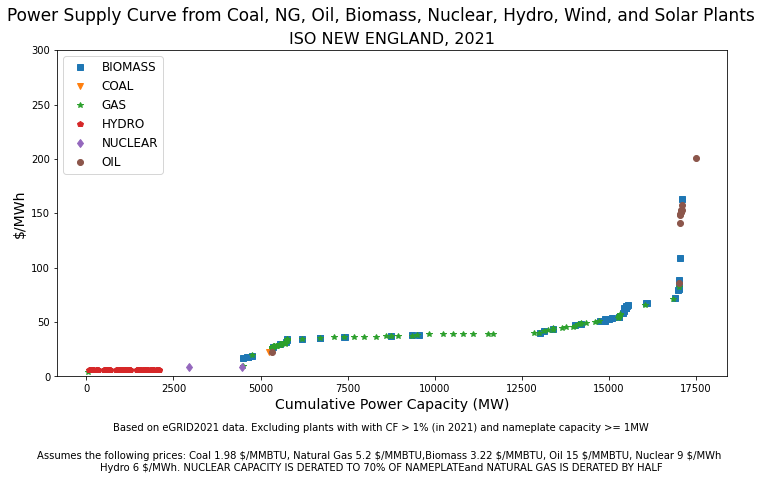

In [ ]:
# 3. Create the supply curve using a scatter plot
# To distinguish the plants by type of fuel we will use different markers
groups = df_isone_base.groupby("PLFUELCT")
list_markers = ['s','v','*','p','d','o','x','+','>','2']

plt.figure(figsize=(12, 6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP_DISRUPT_NUCLEAR"], group["MARG_COST"], 
             marker=list_markers[counter], linestyle="", label=name)
    counter = counter + 1

#Add titles and label axes
plt.suptitle('Power Supply Curve from Coal, NG, Oil, Biomass, Nuclear, Hydro, Wind, and Solar Plants',
          fontsize=17)
plt.title('ISO NEW ENGLAND, 2021', fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.ylim([0,300])
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2021 data. Excluding plants with with CF > 1% (in 2021) and nameplate capacity >= 1MW"
plt.figtext(0.5, 0.0, txt, wrap=True, horizontalalignment='center', fontsize=10)

txt2_1 = 'Assumes the following prices: Coal {} \$/MMBTU, Natural Gas {} \$/MMBTU,'
txt2_2 = 'Biomass {} \$/MMBTU, Oil {} \$/MMBTU, Nuclear {} \$/MWh \n'
txt2_3 = 'Hydro {} \$/MWh. NUCLEAR CAPACITY IS DERATED TO 70% OF NAMEPLATE'
txt2_4 = 'and NATURAL GAS IS DERATED BY HALF'

txt2= (txt2_1 + txt2_2 + txt2_3 + txt2_4).format(AVG_PRICE_COAL, AVG_PRICE_NG, 
                                        AVG_PRICE_BIOM, AVG_PRICE_OIL, 
                                        MARG_COST_NUCLEAR, MARG_COST_HYDRO)
plt.figtext(0.5, -0.09, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + '1e_isone_nuclear_derate_power_supply_curve.png')
plt.show()

In [ ]:
# Estimating the maximum capacity from plants
total_capac_nuclear_disrupt = df_isone_base.NAMEPCAP_DISRUPT_NUCLEAR.sum()

print("""The maximum demand that can be served in ISO New England with the power plants 
      contained in the PLNT21 tab of eGRID2021, that had a capacity of more than 1 MW and
      a CF of more than 1%, and derating the capacity
      of NUCLEAR plants to 70% of nameplate is {:,.2f} MW.""".format(total_capac_nuclear_disrupt))

The maximum demand that can be served in ISO New England with the power plants 
      contained in the PLNT21 tab of eGRID2021, that had a capacity of more than 1 MW and
      a CF of more than 1%, and derating the capacity
      of NUCLEAR plants to 70% of nameplate is 17,567.38 MW.


#### If solar and wind (not derated) are also included:

In [ ]:
#1. Adjust nameplate capacity for natural gas plants
# Create new attribute to store the Nuclear plants  disrupted nameplate capacity
# Initially all the values are equal to the original nameplate
df_isone_all['NAMEPCAP_DISRUPT_NUCLEAR'] = df_isone_all.NAMEPCAP_DISRUPT_NG

# Replace the nameplate capacity of NG plants by half of their nameplate capacity
df_isone_all.loc[df_isone_all.PLFUELCT=='NUCLEAR', 'NAMEPCAP_DISRUPT_NUCLEAR'] = df_isone_all.NAMEPCAP * 0.70
df_isone_all.head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,NAMEPCAP_ADJ,CUM_CAP_ADJ,NAMEPCAP_DISRUPT_NG,CUM_CAP_DISRUPT_NG,NAMEPCAP_DISRUPT_NUCLEAR
2299,ALDI DC 2,ISONE,SOLAR,0.13917,1.2,NaN,1463.0,NaN,0.0,0.167004,0.167004,1.2,1.2,1.2
4671,Sunpin Blandford,ISONE,SOLAR,0.11049,4.7,NaN,4549.0,NaN,0.0,0.519303,0.686307,4.7,5.9,4.7
4673,Sutton Solar CSG,ISONE,SOLAR,0.18878,1.9,NaN,3142.0,NaN,0.0,0.358682,1.044989,1.9,7.8,1.9
4674,Syncarpha Blandford Hybrid CSG,ISONE,SOLAR,0.10261,8.8,0.0,7910.0,0.0,0.0,0.902968,1.947957,8.8,16.6,8.8
4675,Syncarpha Freetown,ISONE,SOLAR,0.19207,3.9,NaN,6562.0,NaN,0.0,0.749073,2.697030,3.9,20.5,3.9


In [ ]:
# 2. Create a column with the cummulative capacity [MW] offered at that MARG_COST
# this info is needed to draw the supply curve
df_isone_all['CUM_CAP_DISRUPT_NUCLEAR'] = df_isone_all.NAMEPCAP_DISRUPT_NUCLEAR.cumsum(skipna=False)
#Show first 5 NUCLEAR planst to see the disrupted nameplate capacity
df_isone_all.loc[df_isone_all.PLFUELCT == 'NUCLEAR',].head(n=5)

,PNAME,ISORTO,PLFUELCT,CAPFAC,NAMEPCAP,PLHTIAN,PLNGENAN,HEAT_RATE,MARG_COST,NAMEPCAP_ADJ,CUM_CAP_ADJ,NAMEPCAP_DISRUPT_NG,CUM_CAP_DISRUPT_NG,NAMEPCAP_DISRUPT_NUCLEAR,CUM_CAP_DISRUPT_NUCLEAR
7309,Seabrook,ISONE,NUCLEAR,0.90590,1242.0,NaN,9856117.0,NaN,9.0,1242.0,4072.893103,1242.0,6660.2,869.40,6287.60
2383,Millstone,ISONE,NUCLEAR,0.90867,2162.9,NaN,17216509.0,NaN,9.0,2162.9,6235.793103,2162.9,8823.1,1514.03,7801.63


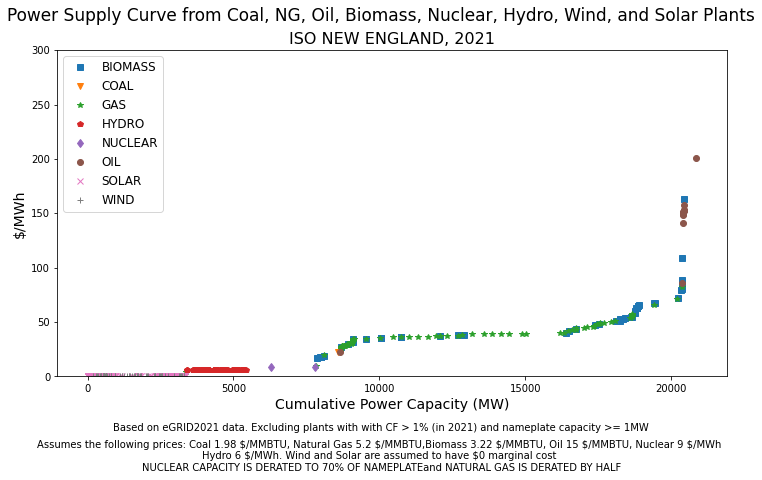

In [ ]:
# 3. Create the supply curve using a scatter plot
# To distinguish the plants by type of fuel we will use different markers
groups = df_isone_all.groupby("PLFUELCT")
list_markers = ['s','v','*','p','d','o','x','+','>','2']

plt.figure(figsize=(12, 6))

#loop to plot each group of plants by type of fuel(different colors and markers)
counter = 0
for name, group in groups:
    plt.plot(group["CUM_CAP_DISRUPT_NUCLEAR"], group["MARG_COST"], marker=list_markers[counter], 
             linestyle="", label=name)
    counter = counter + 1

#Add titles and label axes
plt.suptitle('Power Supply Curve from Coal, NG, Oil, Biomass, Nuclear, Hydro, Wind, and Solar Plants',
          fontsize=17)
plt.title('ISO NEW ENGLAND, 2021', fontsize=16)
plt.xlabel("Cumulative Power Capacity (MW)", fontsize=14)
plt.ylabel("$/MWh",fontsize=14)
plt.ylim([0,300])
plt.legend(fontsize=12)

#Make sure to add a caption that makes this plot a stand-alone piece of information
txt="Based on eGRID2021 data. Excluding plants with with CF > 1% (in 2021) and nameplate capacity >= 1MW"
plt.figtext(0.5, 0.0, txt, wrap=True, horizontalalignment='center', fontsize=10)

txt2_1 = 'Assumes the following prices: Coal {} \$/MMBTU, Natural Gas {} \$/MMBTU,'
txt2_2 = 'Biomass {} \$/MMBTU, Oil {} \$/MMBTU, Nuclear {} \$/MWh \n'
txt2_3 = 'Hydro {} \$/MWh. Wind and Solar are assumed to have \$0 marginal cost \n'
txt2_4 = 'NUCLEAR CAPACITY IS DERATED TO 70% OF NAMEPLATE'
txt2_5 = 'and NATURAL GAS IS DERATED BY HALF'

txt2= (txt2_1 + txt2_2 + txt2_3 + txt2_4 + txt2_5).format(AVG_PRICE_COAL, AVG_PRICE_NG, 
                                                 AVG_PRICE_BIOM, AVG_PRICE_OIL, 
                                                 MARG_COST_NUCLEAR,MARG_COST_HYDRO)
plt.figtext(0.5, -0.09, txt2, wrap=True, horizontalalignment='center', fontsize=10)

#Save plot
plt.savefig(path + '1e_isone_nuclear_derate_power_supply_curve_solar_wind.png')
plt.show()

**What is the highest electricity demand that can be served under these conditions?**

In [ ]:
# Estimating the maximum capacity from plants
total_capac_nuclear_disrupt_solar_wind = df_isone_all.NAMEPCAP_DISRUPT_NUCLEAR.sum()

print('The maximum demand that can be served in ISO New England with the power plants \n' + 
      'contained in the PLNT21 tab of eGRID2021, that had a capacity of more than 1 MW and  \n' + 
      'a CF of more than 1%, without derating WIND AND SOLAR and derating the capacity \n' +
      'of NUCLEAR plants to 70% of nameplate is {:,.2f} MW.'.format(total_capac_nuclear_disrupt_solar_wind))

The maximum demand that can be served in ISO New England with the power plants 
contained in the PLNT21 tab of eGRID2021, that had a capacity of more than 1 MW and  
a CF of more than 1%, without derating WIND AND SOLAR and derating the capacity 
of NUCLEAR plants to 70% of nameplate is 20,907.58 MW.


## f. Highest demand on a winter day 
Highest demand observed on a winter day was 22,818 MW (on Thursday 01/15/2014 )

**Is ISONE power supply adequate to meet the peak demand plus reserves?**


In [ ]:
print("""The maximum demand that can be served in ISO New England with the power 
    plants contained in the PLNT21 tab of eGRID20, that had a capacity of more 
    than 1 MW and a CF of more than 1%, with solar and wind plants derated at 
    their capacity factor of 2021 is {:,.2f} ({:,.2f} if solar and wind 
    resources are not included). So in theory, the ISONE could satisfy this 
    demand plus reserves. Nevertheless a disruption of some of its plants could 
    affect its ability to satisfy this demand, for example, a derating in the 
    capacity of Natural Gas plants by 50% would reduce its capacity to {:,.2f} 
    MW ({:,.2f} MW if solar and wind plants are not included). If these kinds of 
    de-ratings of capacity occurred during the time of high demand, ISONE would 
    not be able to meet demand plus reserves, and outages would occur.""".format(total_capac_all, 
                                                                     total_capac_base, 
                                                                     total_capac_ng_disrupt_solar_wind, 
                                                                     total_capac_ng_disrupt) )

The maximum demand that can be served in ISO New England with the power 
    plants contained in the PLNT21 tab of eGRID20, that had a capacity of more 
    than 1 MW and a CF of more than 1%, with solar and nuclear plants derated at 
    their capacity factor of 2021 is 30,037.79 (29,352.70 if solar and wind 
    resources are not included). So in theory, the ISONE could satisfy this 
    demand plus reserves. Nevertheless a disruption of some of its plants could 
    affect its ability to satisfy this demand, for example, a derating in the 
    capacity of Natural Gas plants by 50% would reduce its capacity to 21,929.05 
    MW (18,588.85 MW if solar and wind plants are not included). If these kinds of 
    de-ratings of capacity occurred during the time of high demand, ISONE would 
    not be able to meet demand plus reserves, and outages would occur.


# 2 (50%) Unit commitment problem :
A balancing authority needs to solve the UC problem for a 3-hours planning horizon. Three thermal generating units are used to supply demands of 160MW, 500MW and 400MW in time periods 1, 2 and 3, respectively. Data on technical limits and economic parameters of the generating units is provided in Table 1. Required spinning reserves during each of the three periods are 160MW, 50MW, and 40MW but we will ignore them in the formulation of this UC problem.

| **Generating Unit** | **$C_g^F$** | **$C_g^{SD}$** | **$C_g^{SU}$** | **$C_g^V$** | **$P_g^{max}$** | **$P_g^{Pmin}$** | **$R_g^{D}$** | **$R_g^{SD}$** | **$R_g^{SU}$** | **$R_g^U$** |
|---------------------|--------|---------|---------|--------|----------|----------|---------|---------|---------|--------|
|        **1**        | 5      | 0.5     | 20      | 0.1    | 350      | 50       | 300     | 300     | 200     | 200    |
|        **2**        | 7      | 0.3     | 18      | 0.125  | 200      | 80       | 150     | 150     | 100     | 100    |
|        **3**        | 6      | 1       | 5       | 0.15   | 140      | 40       | 100     | 100     | 100     | 100    |


<font size ="2">
Table 1: Technical characteristics of generators., where
$C_g^F$ is the Online (fixed) cost of generating unit g (\$/h), $C_g^{SD}$ is the shut-down cost of generating unit g (\$), $C_g^{SU}$ is the Start-up cost of generating unit g (\$),
$C_g^V$ is the Variable cost of generating unit g (\$/MWh),
$P_g^{max}$ is the Power generation capacity of unit g (MW),
$P_g^{Pmin}$, is the minimum power output of unit g (MW),
$R_g^{D}$ is the ramping-down limit of generating unit g (MW/h),
$R_g^{SD}$ is the shut-down ramping limit of generating unit g (MW/h),
$R_g^{SU}$ is the start-up ramping limit of generating unit g(MW/h), 
$R_g^U$, is the ramping-up limit of generating unit g (MW/h)
</font>
---

Assume that at time t=0, units #1 and # 2 are off-line while generating unit# 3 is online and producing 100MW. 
Formulate the unit commitment (UC) problem spelling out all the values and constraints.

### 2.a (2%) 
Write down a list of all the decision variables, spelling out each of them (i.e., do not use the indices to refer to types of decision variables, but rather list them all). The first decision variable in your list is: p1,1=power produced by generator # 1 in hour1. The second element in the list is: p1,1=power produced by generator # 1 in hour 2, and so on.

### 2.b (5%) 
Write down the objective function spelling out all the terms and writing down the values of all the parameters. Explain this function in words.</li>

### 2.c (7%) 
Write down all the constraints that relate the operating status of the plants with the indicator decision variables for shutting down and starting up. These are 18 equations with logical conditions that state that any generator that is online can be shut-down but not started-up and that any generator that is off-line can be started –up but not shut-down.


## 2.d (2%) 
Write down all the equations that ensure that binary decision variables take the value 0 or 1.</li>


# 3 (25%) Self-scheduling problem:
A power producer owns two power generating resources with characteristics as described in Table 2.

Formulate the optimization problem for finding the optimal scheduling of the generating units to maximize profits during the next 5 hours (estimated prices given in table below) (There is no need to find a solution to this problem. Please ignore the constraints for the minimum uptime and minimum down time, and assume that the generating units are off-line and hence have an initial power output of zero).

In [ ]:
%%shell
jupyter nbconvert --to html "/content/gdrive/MyDrive/ENV717_S23_Solutions/A05/ENV717_A5_Solution.ipynb"

[NbConvertApp] WARNING | pattern '/content/gdrive/MyDrive/ENV717_S23_Solutions/A05/ENV717_A5_Solution.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equ

CalledProcessError: ignored